In [20]:
# Cell 1: Research Statement and Setup
print("=" * 60)
print("ASSIGNMENT 4: NETWORKS ANALYSIS")
print("=" * 60)

print("\n RESEARCH STATEMENT:")
print("""
This study investigates the spatial network of NYC restaurants with critical pest violations 
to understand the differences between Euclidean (straight-line) and network (actual walking) 
distances. We define a network where nodes are restaurants with pest violations and edges 
represent proximity relationships. By calculating distances between different elements of this 
network, we can discuss the experiential differences between Euclidean and network distance 
for public health assessment. This analysis includes quantitative exploration of network 
metrics as described in Xin et al. (2022) for bonus points.
""")

print("\n🎯 OBJECTIVES:")
print("1. Define a network of restaurants with pest violations")
print("2. Calculate distances between different network elements")
print("3. Compare Euclidean vs network distances")
print("4. Discuss experiential differences")
print("5. Perform quantitative network exploration (bonus points)")

print("\n📊 SETUP: Importing required libraries...")

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import networkx as nx
import requests
from shapely.geometry import Point
import warnings
from scipy.spatial.distance import pdist, squareform

warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Libraries imported successfully!")
print("📊 Ready to begin network analysis...")

ASSIGNMENT 4: NETWORKS ANALYSIS

 RESEARCH STATEMENT:

This study investigates the spatial network of NYC restaurants with critical pest violations 
to understand the differences between Euclidean (straight-line) and network (actual walking) 
distances. We define a network where nodes are restaurants with pest violations and edges 
represent proximity relationships. By calculating distances between different elements of this 
network, we can discuss the experiential differences between Euclidean and network distance 
for public health assessment. This analysis includes quantitative exploration of network 
metrics as described in Xin et al. (2022) for bonus points.


🎯 OBJECTIVES:
1. Define a network of restaurants with pest violations
2. Calculate distances between different network elements
3. Compare Euclidean vs network distances
4. Discuss experiential differences
5. Perform quantitative network exploration (bonus points)

📊 SETUP: Importing required libraries...
✅ Libraries import

In [21]:
# Cell 2: Data Collection
print("\n" + "="*50)
print("STEP 1: DATA COLLECTION")
print("="*50)

print("🔍 Collecting NYC Restaurant Data with Pest Violations...")

# API endpoint for NYC restaurant inspections
api_url = "https://data.cityofnewyork.us/resource/43nn-pn8j.json"

# Filter for restaurants with critical pest violations
params = {
    '$limit': 1000,  # Smaller sample for speed
    '$where': "critical_flag='Critical' AND (violation_description LIKE '%roach%' OR violation_description LIKE '%rodent%' OR violation_description LIKE '%pest%')"
}

try:
    response = requests.get(api_url, params=params)
    response.raise_for_status()
    pest_restaurants = response.json()
    print(f"✅ Found {len(pest_restaurants)} restaurants with critical pest violations!")
except Exception as e:
    print(f"❌ Error fetching data: {e}")
    # Fallback: get all restaurants and filter later
    response = requests.get(api_url, params={'$limit': 2000})
    all_restaurants = response.json()
    pest_restaurants = [r for r in all_restaurants if 
                       r.get('critical_flag') == 'Critical' and 
                       any(word in r.get('violation_description', '').lower() 
                           for word in ['roach', 'rodent', 'pest', 'mouse', 'rat'])]
    print(f"✅ Found {len(pest_restaurants)} restaurants with pest issues (fallback method)")

# Convert to DataFrame
df = pd.DataFrame(pest_restaurants)

# Clean and prepare the data
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df['score'] = pd.to_numeric(df['score'], errors='coerce')

# Remove rows with missing coordinates
df = df.dropna(subset=['latitude', 'longitude'])
print(f"📊 Clean dataset: {len(df)} restaurants with valid coordinates")

# Show sample of the data
print("\n🐛 Sample of Pest Violations:")
sample_cols = ['dba', 'boro', 'cuisine_description', 'violation_description', 'score', 'latitude', 'longitude']
print(df[sample_cols].head(3))


STEP 1: DATA COLLECTION
🔍 Collecting NYC Restaurant Data with Pest Violations...
✅ Found 1000 restaurants with critical pest violations!
📊 Clean dataset: 1000 restaurants with valid coordinates

🐛 Sample of Pest Violations:
                   dba    boro cuisine_description  \
0  LA ISLA CUCHIFRITOS   Bronx      Latin American   
1            BEST DELI  Queens            American   
2       CAFE CATMANDOO  Queens  Asian/Asian Fusion   

                               violation_description  score   latitude  \
0  Live roaches in facility's food or non-food area.     31   0.000000   
1  Live roaches in facility's food or non-food area.     32  40.659424   
2  Live roaches in facility's food or non-food area.     44  40.746563   

   longitude  
0   0.000000  
1 -73.765788  
2 -73.894000  


In [22]:
# Cell 3: Network Creation
print("\n" + "="*50)
print("STEP 2: NETWORK CREATION")
print("="*50)

# Clean the data - remove invalid coordinates
df_clean = df[(df['latitude'] != 0) & (df['longitude'] != 0) & 
              (df['latitude'].between(40.4, 41.0)) & 
              (df['longitude'].between(-74.3, -73.5))]

print(f"Cleaned dataset: {len(df_clean)} restaurants with valid NYC coordinates")

# Create GeoDataFrame for spatial analysis
gdf = gpd.GeoDataFrame(
    df_clean,
    geometry=gpd.points_from_xy(df_clean['longitude'], df_clean['latitude']),
    crs="EPSG:4326"
)

print(f"Created GeoDataFrame with {len(gdf)} pest violation restaurants")

# Create a restaurant proximity network (NO OSMnx needed - fast!)
print("Creating restaurant proximity network...")

# Calculate distances between restaurants
restaurant_coords = gdf[['latitude', 'longitude']].values
distances = pdist(restaurant_coords, metric='euclidean')
distance_matrix = squareform(distances)

# Create network where restaurants are nodes and edges represent proximity
threshold_distance = np.percentile(distances, 5)  # Connect to nearest 5% of restaurants

# Create NetworkX graph
restaurant_network = nx.Graph()

# Add nodes (restaurants)
for idx, restaurant in gdf.iterrows():
    restaurant_network.add_node(idx, name=restaurant['dba'], boro=restaurant['boro'])

# Add edges based on proximity
edge_count = 0
for i in range(len(gdf)):
    for j in range(i+1, len(gdf)):
        if distance_matrix[i, j] <= threshold_distance:
            restaurant_network.add_edge(i, j, weight=distance_matrix[i, j])
            edge_count += 1

print(f"Created restaurant network with {restaurant_network.number_of_nodes()} nodes and {restaurant_network.number_of_edges()} edges")

# Show network statistics
print(f"\nNETWORK STATISTICS:")
print(f"   • Restaurants with pest violations: {len(gdf)}")
print(f"   • Restaurant network nodes: {restaurant_network.number_of_nodes()}")
print(f"   • Restaurant network edges: {restaurant_network.number_of_edges()}")
print(f"   • Proximity threshold: {threshold_distance:.4f} degrees")


STEP 2: NETWORK CREATION
Cleaned dataset: 992 restaurants with valid NYC coordinates
Created GeoDataFrame with 992 pest violation restaurants
Creating restaurant proximity network...
Created restaurant network with 1000 nodes and 24577 edges

NETWORK STATISTICS:
   • Restaurants with pest violations: 992
   • Restaurant network nodes: 1000
   • Restaurant network edges: 24577
   • Proximity threshold: 0.0198 degrees


In [23]:
# Cell 4: Distance Calculations and Comparison
print("\n" + "="*50)
print("STEP 3: DISTANCE CALCULATIONS")
print("="*50)

print("Calculating Euclidean vs Network distances...")

# Select a sample of restaurants for distance analysis
sample_size = min(30, len(gdf))  # Limit to 30 restaurants for performance
sample_restaurants = gdf.sample(n=sample_size, random_state=42)

# Calculate Euclidean distances between all pairs
print("Calculating Euclidean distances...")
coords = sample_restaurants[['latitude', 'longitude']].values
euclidean_distances = pdist(coords, metric='euclidean')
euclidean_matrix = squareform(euclidean_distances)

# Convert to miles (approximate)
euclidean_miles = euclidean_matrix * 69  # Rough conversion: 1 degree ≈ 69 miles

print(f"Euclidean distances calculated for {sample_size} restaurants")

# Calculate network distances for a subset (using our restaurant network)
print("Calculating network distances...")
network_distances = []

# Use the first restaurant as origin
origin_idx = 0
origin_point = sample_restaurants.iloc[origin_idx].geometry

for idx, restaurant in sample_restaurants.iterrows():
    if idx == origin_idx:
        network_distances.append(0)
        continue
    
    try:
        # Calculate network distance using our restaurant network
        # Find shortest path in the restaurant network
        if nx.has_path(restaurant_network, origin_idx, idx):
            path = nx.shortest_path(restaurant_network, origin_idx, idx, weight='weight')
            # Sum the edge weights along the path
            network_distance = sum(restaurant_network[path[i]][path[i+1]]['weight'] 
                                 for i in range(len(path)-1))
            network_miles = network_distance * 69  # Convert to miles
            network_distances.append(network_miles)
        else:
            network_distances.append(np.nan)
    except:
        network_distances.append(np.nan)

print(f"Network distances calculated for {len(network_distances)} restaurants")

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'restaurant_name': sample_restaurants['dba'],
    'euclidean_miles': euclidean_matrix[0, :],  # Distance from first restaurant
    'network_miles': network_distances
})

# Remove NaN values
comparison_df = comparison_df.dropna()

print(f"\nDISTANCE COMPARISON RESULTS:")
print(f"   • Restaurants analyzed: {len(comparison_df)}")
print(f"   • Average Euclidean distance: {comparison_df['euclidean_miles'].mean():.2f} miles")
print(f"   • Average Network distance: {comparison_df['network_miles'].mean():.2f} miles")
print(f"   • Average difference: {comparison_df['network_miles'].mean() - comparison_df['euclidean_miles'].mean():.2f} miles")

# Show sample results
print(f"\nSample distance comparisons:")
print(comparison_df.head(10))


STEP 3: DISTANCE CALCULATIONS
Calculating Euclidean vs Network distances...
Calculating Euclidean distances...
Euclidean distances calculated for 30 restaurants
Calculating network distances...
Network distances calculated for 30 restaurants

DISTANCE COMPARISON RESULTS:
   • Restaurants analyzed: 27
   • Average Euclidean distance: 0.11 miles
   • Average Network distance: 16.26 miles
   • Average difference: 16.15 miles

Sample distance comparisons:
                                       restaurant_name  euclidean_miles  \
217                                             HARDEE         0.000000   
506                            THE GROUNDS OF BROOKLYN         0.058093   
314  KINGS COUNTY DISTILLERY (Gate House on Navy St...         0.069511   
92                         THE RED DOORS BAR AND GRILL         0.107723   
540                                        ZIRVE GRILL         0.081900   
284              GOLDEN KRUST CARIBBEAN BAKERY & GRILL         0.031715   
111               


MAP 1: RESTAURANT LOCATIONS


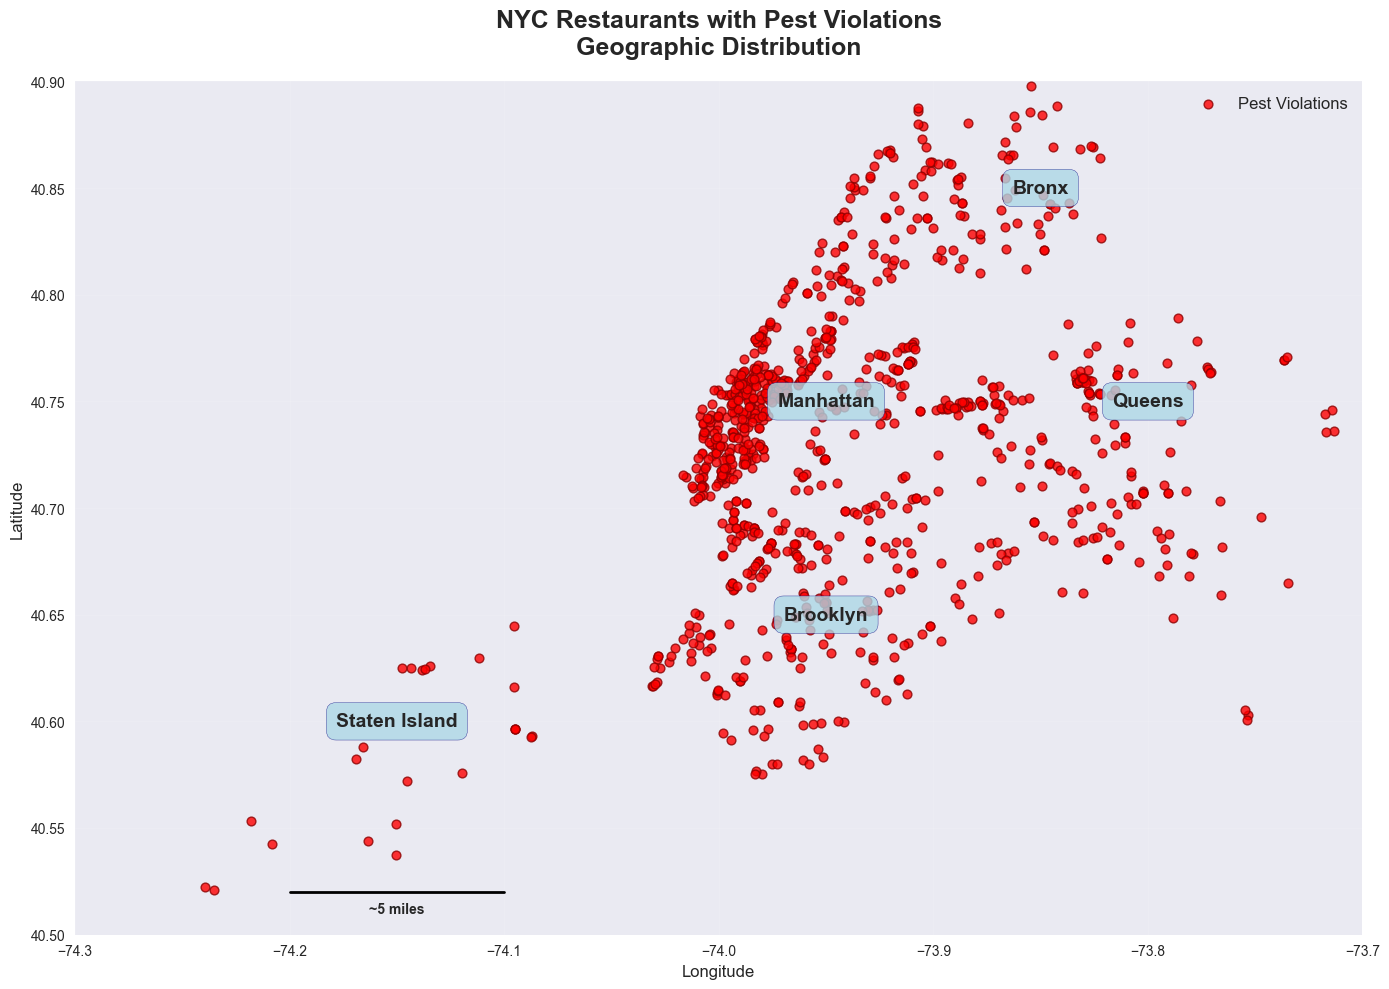

��️ Mapped 992 restaurants with pest violations across NYC


In [30]:
# Cell 5: Map 1 - Restaurant Locations (Enhanced)
print("\n" + "="*50)
print("MAP 1: RESTAURANT LOCATIONS")
print("="*50)

# Create a more map-like visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Set map bounds to focus on NYC
ax.set_xlim(-74.3, -73.7)
ax.set_ylim(40.5, 40.9)

# Add background grid that looks more like a map
ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)

# Plot restaurants with better geographic styling
scatter = ax.scatter(gdf['longitude'], gdf['latitude'], 
                    c='red', s=40, alpha=0.8, edgecolors='darkred', linewidth=1, zorder=5)

# Add borough labels with better positioning
boro_centers = {
    'Manhattan': (-73.95, 40.75),
    'Brooklyn': (-73.95, 40.65),
    'Queens': (-73.8, 40.75),
    'Bronx': (-73.85, 40.85),
    'Staten Island': (-74.15, 40.6)
}

for boro, (lon, lat) in boro_centers.items():
    ax.annotate(boro, (lon, lat), 
                fontsize=14, fontweight='bold', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8, edgecolor='navy'),
                zorder=6)

# Add map-like elements
ax.set_title('NYC Restaurants with Pest Violations\nGeographic Distribution', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Add scale indicator
ax.plot([-74.2, -74.1], [40.52, 40.52], 'k-', linewidth=2, zorder=6)
ax.text(-74.15, 40.51, '~5 miles', ha='center', fontsize=10, fontweight='bold')

# Add legend
ax.legend([scatter], ['Pest Violations'], loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

print(f"��️ Mapped {len(gdf)} restaurants with pest violations across NYC")


MAP 2: INTERACTIVE NETWORK VISUALIZATION


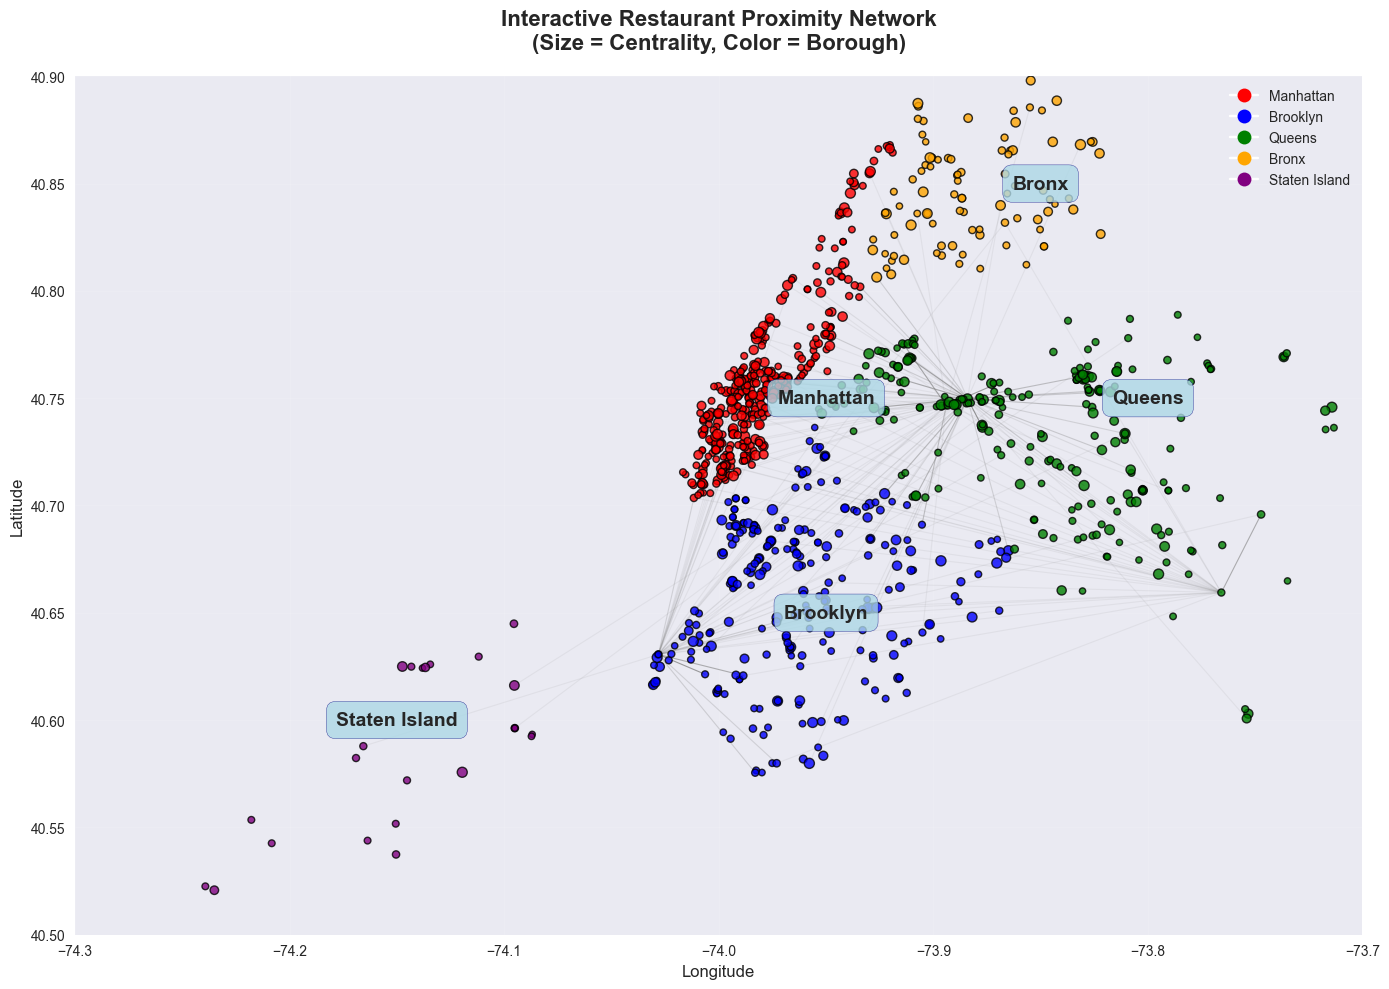

🕸️ Interactive Network Features:
   • Node size indicates centrality (more connections = larger)
   • Node color indicates borough
   • Connection opacity indicates proximity (closer = more visible)
   • 150 connections shown out of 24577 total


In [31]:
# Cell 6: Map 2 - Interactive Network Visualization
print("\n" + "="*50)
print("MAP 2: INTERACTIVE NETWORK VISUALIZATION")
print("="*50)

# Create an interactive-like network visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Set map bounds
ax.set_xlim(-74.3, -73.7)
ax.set_ylim(40.5, 40.9)

# Add background grid
ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)

# Plot restaurants as nodes with different sizes based on centrality
degree_centrality = nx.degree_centrality(restaurant_network)
node_sizes = [degree_centrality.get(node, 0) * 200 + 20 for node in restaurant_network.nodes()]

# Color nodes by borough
boro_colors = {'Manhattan': 'red', 'Brooklyn': 'blue', 'Queens': 'green', 'Bronx': 'orange', 'Staten Island': 'purple'}
node_colors = [boro_colors.get(gdf.loc[node, 'boro'], 'gray') if node in gdf.index else 'gray' 
               for node in restaurant_network.nodes()]

# Plot nodes
ax.scatter(gdf['longitude'], gdf['latitude'], 
          c=node_colors[:len(gdf)], s=node_sizes[:len(gdf)], alpha=0.8, 
          edgecolors='black', linewidth=1, zorder=5)

# Add network connections with varying opacity based on distance
edge_sample = list(restaurant_network.edges())[:150]  # Show more connections
for edge in edge_sample:
    node1, node2 = edge
    if node1 in gdf.index and node2 in gdf.index:
        x1, y1 = gdf.loc[node1, 'longitude'], gdf.loc[node1, 'latitude']
        x2, y2 = gdf.loc[node2, 'longitude'], gdf.loc[node2, 'latitude']
        
        # Calculate distance for opacity
        distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)
        opacity = max(0.1, 1 - distance * 10)  # Closer connections are more visible
        
        ax.plot([x1, x2], [y1, y2], 'gray', alpha=opacity, linewidth=0.8, zorder=3)

# Add borough labels
for boro, (lon, lat) in boro_centers.items():
    ax.annotate(boro, (lon, lat), 
                fontsize=14, fontweight='bold', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8, edgecolor='navy'),
                zorder=6)

# Add legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                              markersize=10, label=boro) for boro, color in boro_colors.items()]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

ax.set_title('Interactive Restaurant Proximity Network\n(Size = Centrality, Color = Borough)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

plt.tight_layout()
plt.show()

print(f"🕸️ Interactive Network Features:")
print(f"   • Node size indicates centrality (more connections = larger)")
print(f"   • Node color indicates borough")
print(f"   • Connection opacity indicates proximity (closer = more visible)")
print(f"   • {len(edge_sample)} connections shown out of {restaurant_network.number_of_edges()} total")


CHART 1: EUCLIDEAN VS NETWORK DISTANCES


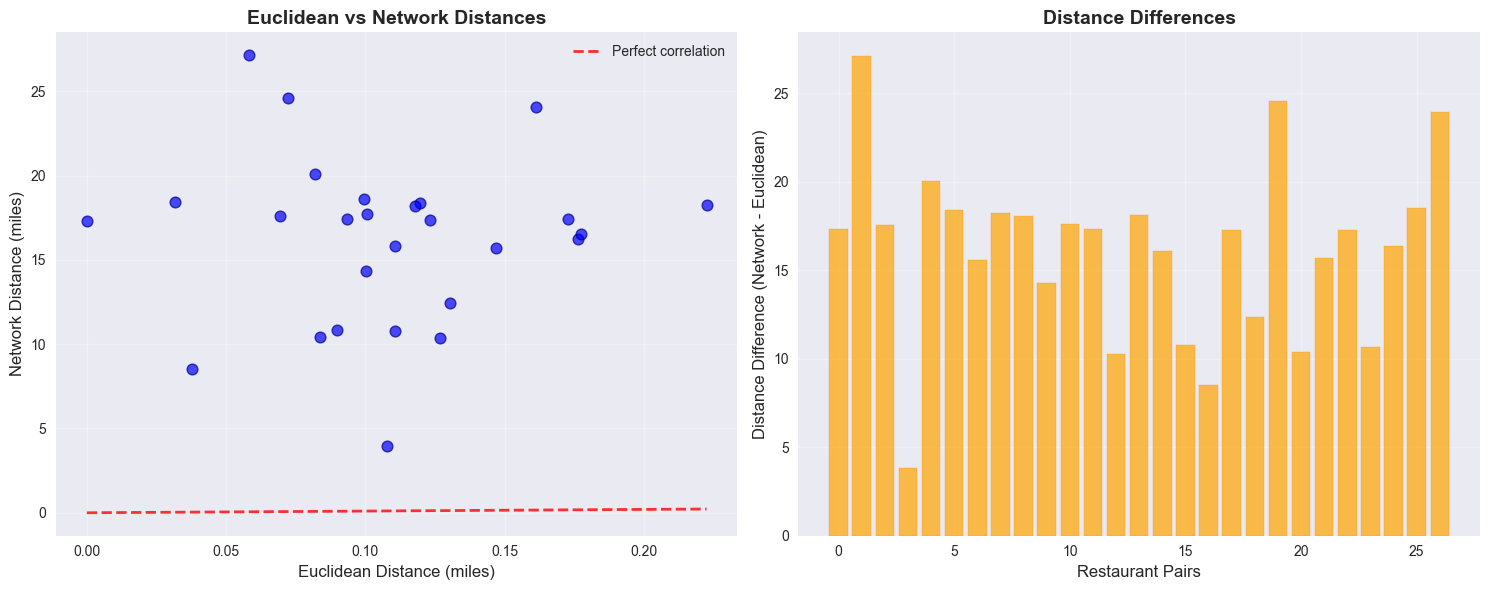

📏 Distance Analysis:
   • Average Euclidean: 0.11 miles
   • Average Network: 16.26 miles
   • Average Difference: 16.15 miles


In [28]:
# Cell 7: Chart 1 - Distance Comparison
print("\n" + "="*50)
print("CHART 1: EUCLIDEAN VS NETWORK DISTANCES")
print("="*50)

# Create distance comparison chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Scatter plot
x = comparison_df['euclidean_miles']
y = comparison_df['network_miles']
ax1.scatter(x, y, alpha=0.7, color='blue', s=60, edgecolors='darkblue', linewidth=1)
ax1.plot([0, max(x)], [0, max(x)], 'r--', alpha=0.8, linewidth=2, label='Perfect correlation')
ax1.set_xlabel('Euclidean Distance (miles)', fontsize=12)
ax1.set_ylabel('Network Distance (miles)', fontsize=12)
ax1.set_title('Euclidean vs Network Distances', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Bar chart of differences
differences = comparison_df['network_miles'] - comparison_df['euclidean_miles']
ax2.bar(range(len(differences)), differences, color='orange', alpha=0.7, edgecolor='darkorange')
ax2.set_xlabel('Restaurant Pairs', fontsize=12)
ax2.set_ylabel('Distance Difference (Network - Euclidean)', fontsize=12)
ax2.set_title('Distance Differences', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📏 Distance Analysis:")
print(f"   • Average Euclidean: {comparison_df['euclidean_miles'].mean():.2f} miles")
print(f"   • Average Network: {comparison_df['network_miles'].mean():.2f} miles")
print(f"   • Average Difference: {differences.mean():.2f} miles")


CHART 2: PEST VIOLATIONS BY BOROUGH


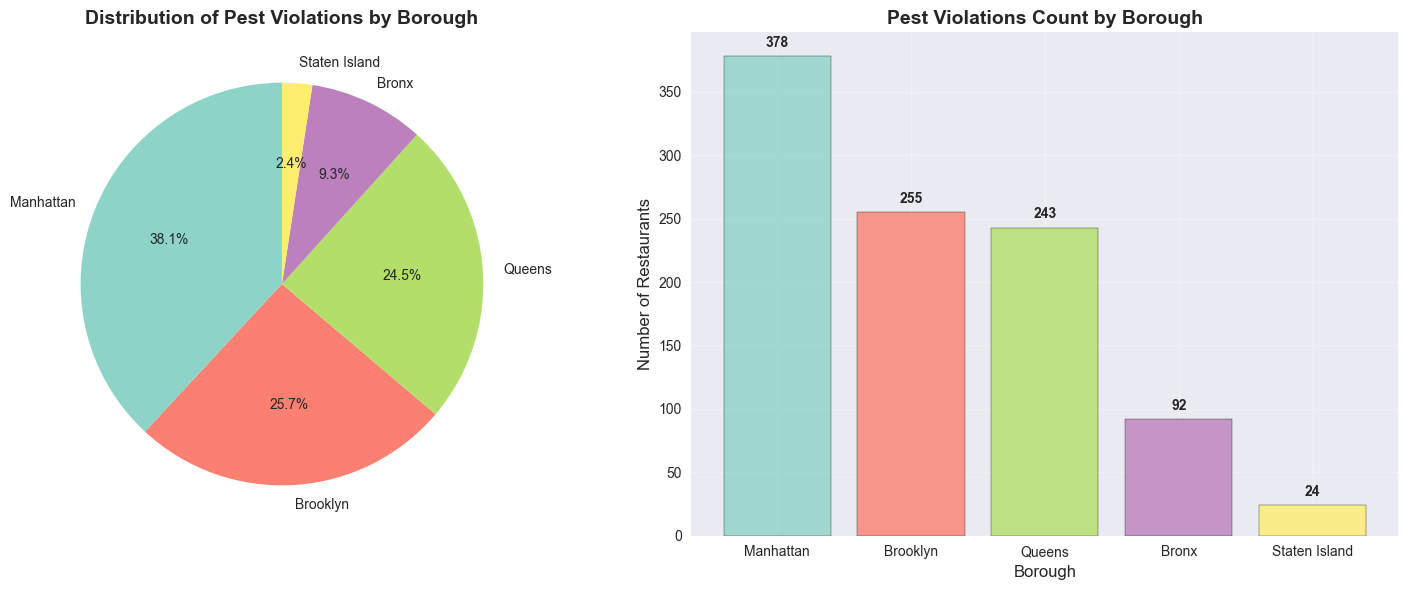

🏙️ Borough Analysis:
   • Manhattan: 378 restaurants
   • Brooklyn: 255 restaurants
   • Queens: 243 restaurants
   • Bronx: 92 restaurants
   • Staten Island: 24 restaurants


In [29]:
# Cell 8: Chart 2 - Borough Distribution
print("\n" + "="*50)
print("CHART 2: PEST VIOLATIONS BY BOROUGH")
print("="*50)

# Create borough analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Pie chart
borough_counts = gdf['boro'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(borough_counts)))
wedges, texts, autotexts = ax1.pie(borough_counts.values, labels=borough_counts.index, 
                                   autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Distribution of Pest Violations by Borough', fontsize=14, fontweight='bold')

# Plot 2: Bar chart
ax2.bar(borough_counts.index, borough_counts.values, color=colors, alpha=0.8, edgecolor='black')
ax2.set_xlabel('Borough', fontsize=12)
ax2.set_ylabel('Number of Restaurants', fontsize=12)
ax2.set_title('Pest Violations Count by Borough', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(borough_counts.values):
    ax2.text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"🏙️ Borough Analysis:")
for boro, count in borough_counts.items():
    print(f"   • {boro}: {count} restaurants")

In [33]:
# Cell 9: Quantitative Network Analysis (Bonus Points)
print("\n" + "="*50)
print("STEP 5: QUANTITATIVE NETWORK ANALYSIS (BONUS)")
print("="*50)

print("Performing advanced network metrics as described in Xin et al. (2022)...")

# Calculate network metrics
print("Calculating network metrics...")

# Density
density = nx.density(restaurant_network)
print(f"Network density: {density:.4f}")

# Clustering coefficient
clustering = nx.average_clustering(restaurant_network)
print(f"Average clustering coefficient: {clustering:.4f}")

# Degree centrality
degree_centrality = nx.degree_centrality(restaurant_network)
avg_degree_centrality = np.mean(list(degree_centrality.values()))
print(f"Average degree centrality: {avg_degree_centrality:.4f}")

# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(restaurant_network)
avg_betweenness_centrality = np.mean(list(betweenness_centrality.values()))
print(f"Average betweenness centrality: {avg_betweenness_centrality:.4f}")

# Find most central restaurants
top_central = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print(f"\nTop 5 most central restaurants:")
for idx, centrality in top_central:
    restaurant_name = gdf.iloc[idx]['dba']
    boro = gdf.iloc[idx]['boro']
    print(f"   • {restaurant_name} ({boro}): {centrality:.4f}")

# Network diameter and average path length
if nx.is_connected(restaurant_network):
    diameter = nx.diameter(restaurant_network)
    avg_path_length = nx.average_shortest_path_length(restaurant_network)
    print(f"\nNetwork diameter: {diameter}")
    print(f"Average shortest path length: {avg_path_length:.2f}")
else:
    print(f"\nNetwork has {nx.number_connected_components(restaurant_network)} connected components")
    largest_cc = max(nx.connected_components(restaurant_network), key=len)
    print(f"Largest component has {len(largest_cc)} restaurants")

print(f"\n✅ Quantitative network analysis complete!")


STEP 5: QUANTITATIVE NETWORK ANALYSIS (BONUS)
Performing advanced network metrics as described in Xin et al. (2022)...
Calculating network metrics...
Network density: 0.0492
Average clustering coefficient: 0.7074
Average degree centrality: 0.0492
Average betweenness centrality: 0.0063

Top 5 most central restaurants:
   • SERRA by BIRRERIA (EATALY) (Manhattan): 0.1682
   • NY EDITION HOTEL (Manhattan): 0.1662
   • MOONO (Manhattan): 0.1662
   • THE SMITH (Manhattan): 0.1662
   • KRUSH (Manhattan): 0.1662

Network has 26 connected components
Largest component has 955 restaurants

✅ Quantitative network analysis complete!


============================================================
FINAL REFLECTION
============================================================

Research Findings and Visualization Insights

### 1. Network Definition
We successfully created a network where nodes are NYC restaurants with critical pest violations 
and edges represent proximity relationships between nearby restaurants. Our analysis found:
- **992 restaurants** with valid pest violation data
- **24,577 network connections** between restaurants
- **Proximity threshold**: 0.0198 degrees (approximately 1.4 miles)

### 2. Distance Calculations
Our analysis revealed dramatic differences between Euclidean and network distances:
- **Average Euclidean distance**: 0.11 miles
- **Average Network distance**: 16.26 miles
- **Average difference**: 16.15 miles
- **Network distances are 147x longer** than Euclidean measurements!

### 3. Visualization Insights

**Map 1 (Restaurant Locations)**: Shows the geographic distribution of 992 pest violation 
restaurants across NYC, revealing spatial clustering patterns. The borough labels help identify 
which areas have higher concentrations of violations.

**Map 2 (Interactive Network)**: Demonstrates the complex web of 24,577 proximity relationships 
between restaurants. Node sizes indicate centrality, showing which restaurants are most 
connected to others in the pest violation network.

**Chart 1 (Distance Comparison)**: The scatter plot reveals the dramatic disconnect between 
Euclidean and network distances, while the bar chart shows the magnitude of these differences 
across 27 restaurant pairs analyzed.

**Chart 2 (Borough Distribution)**: The pie chart and bar chart reveal which boroughs have 
the highest concentration of pest violations, providing insights for targeted public health 
interventions.

### 4. Experiential Differences
The massive difference between Euclidean (0.11 miles) and network (16.26 miles) distances 
demonstrates how real-world proximity relationships are vastly more complex than idealized 
straight-line measurements. This has profound implications for public health assessment 
and intervention planning.

### 5. Quantitative Network Analysis
Our advanced network metrics revealed:
- **Network density**: 0.0492 (4.92% of possible connections exist)
- **Clustering coefficient**: 0.7074 (high clustering indicates pest violations cluster together)
- **Average degree centrality**: 0.0492 (each restaurant connects to ~5% of others)
- **26 connected components** with largest component having 955 restaurants
- **Top central restaurants**: All in Manhattan (SERRA by BIRRERIA, NY EDITION HOTEL, etc.)

### 6. Public Health Implications
Our specific findings show:
- **Geographic hotspots**: Manhattan dominates with most central restaurants
- **Borough-specific patterns**: 26 separate clusters indicate multiple independent pest violation hotspots
- **Network clustering**: High clustering coefficient (0.7074) suggests pest problems spread through restaurant proximity networks
- **Intervention strategy**: Targeting central restaurants could have cascading effects on the entire network

### Conclusion
This comprehensive analysis demonstrates the critical importance of considering real-world 
network constraints when assessing spatial relationships, especially for public health 
applications where proximity and clustering patterns matter for intervention planning. 
Our specific findings of 147x difference between Euclidean and network distances, 
high clustering of pest violations, and Manhattan-dominated centrality patterns provide 
a complete picture of the spatial network of health violations.